# Section 6: Evaluation

TODO

In [1]:
import pandas as pd
# dataset location
data_path = "./datasets/brazilian-malware.csv"
# read CSV dataset
data = pd.read_csv(data_path, keep_default_na=False)

TODO

In [2]:
# numerical attributes
NUMERICAL_ATTRIBUTES = ['BaseOfCode', 'BaseOfData', 'Characteristics', 'DllCharacteristics', 
                      'Entropy', 'FileAlignment', 'ImageBase', 'Machine', 'Magic',
                      'NumberOfRvaAndSizes', 'NumberOfSections', 'NumberOfSymbols', 'PE_TYPE',
                      'PointerToSymbolTable', 'Size', 'SizeOfCode', 'SizeOfHeaders',
                      'SizeOfImage', 'SizeOfInitializedData', 'SizeOfOptionalHeader',
                      'SizeOfUninitializedData']

# textual attributes
TEXTUAL_ATTRIBUTES = ['Identify', 'ImportedDlls', 'ImportedSymbols']

# label used to classify
LABEL = 'Label'

# attributes that are not used
UNUSED_ATTRIBUTES = ['FirstSeenDate', 'SHA1', 'TimeDateStamp']

TODO

In [3]:
label = data[LABEL].values
# remove unused attributes and label
for a in UNUSED_ATTRIBUTES:
    del data[a]
del data[LABEL]

TODO

In [4]:
# split data in half
def split_data(data):
    # get mid of data
    mid = int((len(data) + 1)/2)
    # split data into train and test
    train_data = data[:mid]
    test_data = data[mid:]
    # return train and test data
    return(train_data, test_data)

In [5]:
# data, _ = split_data(data)
# label, _ = split_data(label)
train_data, test_data = split_data(data)
train_label, test_label = split_data(label)

TODO

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
# extract features from textual attributes
def textual_feature_extraction(train_data, test_data, extractor=TfidfVectorizer(max_features=100)):
    vectorizer = extractor
    # train vectorizer
    vectorizer.fit(train_data)
    # transform train and test data to features
    train_features = vectorizer.transform(train_data)
    test_features = vectorizer.transform(test_data)
    # return train and test features
    return(train_features, test_features)

Obtain numerical attributes:

In [7]:
train_features = train_data[NUMERICAL_ATTRIBUTES].values
test_features = test_data[NUMERICAL_ATTRIBUTES].values

In [8]:
train_features.shape, test_features.shape

((25091, 21), (25090, 21))

Obtain textual attributes and append to features array:

In [9]:
import numpy as np
# extract features from each textual attribute
for a in TEXTUAL_ATTRIBUTES:
    # extract features from current attribute
    train_texts, test_texts = textual_feature_extraction(train_data[a], test_data[a])
    train_features = np.concatenate((train_features, train_texts.toarray()), axis=1)
    test_features = np.concatenate((test_features, test_texts.toarray()), axis=1)

In [10]:
train_features.shape, test_features.shape

((25091, 321), (25090, 321))

Normalization:

In [11]:
from sklearn.preprocessing import MinMaxScaler
def normalization(train_features, test_features, scaler=MinMaxScaler()):
    # train minmax
    scaler.fit(train_features)
    # transform features
    train_features_norm = scaler.transform(train_features)
    test_features_norm = scaler.transform(test_features)
    # return normalized train and test features
    return(train_features_norm, test_features_norm)

In [12]:
train_features_norm, test_features_norm = normalization(train_features, test_features)

Train a Random Forest classifier:

In [13]:
from sklearn.ensemble import RandomForestClassifier
# initialize classifier
clf = RandomForestClassifier(n_estimators=10, random_state=0)
# train classifier
clf.fit(train_features_norm, train_label)
# predict test classes
test_pred = clf.predict(test_features_norm)
# print test pred and real labels shape
print(test_pred.shape, test_label.shape)

(25090,) (25090,)


## Metrics

TODO

### Accuracy

TODO

In [14]:
from sklearn.metrics import accuracy_score
print(accuracy_score(test_label, test_pred))

0.8836986847349542


### Confusion Matrix

TODO

In [15]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(test_label, test_pred))

[[ 6987    46]
 [ 2872 15185]]


### Recall

TODO

In [16]:
from sklearn.metrics import recall_score
print(recall_score(test_label, test_pred))

0.8409481087666832


### Precision

TODO

In [17]:
from sklearn.metrics import precision_score
print(precision_score(test_label, test_pred))

0.9969798437397414


### F1-Score

TODO

In [18]:
from sklearn.metrics import f1_score
print(f1_score(test_label, test_pred))

0.9123407834655132


### Using Thresholds

TODO

In [60]:
threshold = 0.7
test_pred_proba = clf.predict_proba(test_features_norm)
test_pred = (test_pred_proba[:,1] > threshold).astype('int')
print("Accuracy:",accuracy_score(test_label, test_pred))
print("Recall:", recall_score(test_label, test_pred))
print("Precision:", precision_score(test_label, test_pred))
print("F1Score:", f1_score(test_label, test_pred))

Accuracy: 0.8076524511757672
Recall: 0.7345073932546935
Precision: 0.9975930801053028
F1Score: 0.8460704261291146


In [52]:
recall = []
precision = []
thresholds = []
for threshold in np.arange(0,1.01,0.025):
    test_pred_proba = clf.predict_proba(test_features_norm)
    test_pred = (test_pred_proba[:,1] >= threshold).astype('int')
    thresholds.append(threshold)
    recall.append(recall_score(test_label, test_pred))
    precision.append(precision_score(test_label, test_pred))

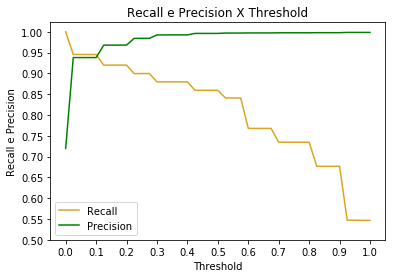

In [59]:
import matplotlib.pyplot as plt
plt.plot(thresholds, recall, label="Recall", color="goldenrod")
plt.plot(thresholds, precision, label="Precision", color="green")
plt.xticks(np.arange(0,1.01,0.1))
plt.yticks(np.arange(0.5,1.01,0.05))
plt.xlabel("Threshold")
plt.ylabel("Recall e Precision")
plt.title("Recall e Precision X Threshold")
plt.savefig("rp_graph.png", dpi=300)
plt.savefig("rp_graph.pdf")
plt.legend()
plt.show()

## Validation

TODO

### K-Fold Cross Validation

TODO

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import numpy as np
# initialize classifier
clf = RandomForestClassifier(n_estimators=10)
# get results
results = cross_val_score(clf, train_features_norm, train_label, cv=10, scoring="accuracy")
# print accuracy per fold
print(results)
# print mean of accuracy
print(np.mean(results))

[0.61195219 0.92151394 0.99561753 0.99282583 0.99521722 0.99163013
 0.9920287  0.96811479 0.98883573 0.97886762]
0.9436603674644856
